In [2]:
import paddle as P 
import paddle.nn as nn 
import paddle.nn.functional as F 
from paddle.io import Dataset, DataLoader 
import paddle.vision.transforms as trans 
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import cv2

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


# Global Variable

In [3]:
#
path_image = '/home/aistudio/data/celeba/img_align_celeba/'
# image_size = 64
#
channel_g = 64
channel_d = 64
dim_latent = 100
batch_size = 128
epochs = 200
learning_rate = 1e-4
step_g = 1
path_work = '/home/aistudio/work/bgan/'

# Data

In [4]:
class Dataset_GAN(Dataset):
    #
    def __init__(self, path_image=path_image):
        self.path_image = path_image
        self.list_image = os.listdir(path_image)
    #
    def __getitem__(self, idx):
        image = cv2.imread(self.path_image + self.list_image[idx]) / 127.5 -1
        # image = np.array(Image.open(self.path_image + self.list_image[idx])) / 127.5 -1
        # h_random = np.random.randint(20, 198-128)
        # w_random = np.random.randint(0, 178-128)
        # image = image[h_random:h_random+128, w_random:w_random+128, :]
        image = image[20:198, :, :]
        image = cv2.resize(image, (64, 64))
        if np.random.randint(2):
            image = image[:, ::-1, :]
        image = image[:, :, ::-1]
        image = image.transpose([2,0,1])
        return image.astype('float32')
    #
    def __len__(self):
        return len(self.list_image)


import numpy as np
from paddle.io import DataLoader, Dataset

class RandomDataset(Dataset):
    def __getitem__(self, idx):
        data = np.random.random((2, 3)).astype('float32')

        return data

    def __len__(self):
        return 10

dataset = RandomDataset()
loader = DataLoader(dataset, batch_size=1)
data = next(loader())

In Paddle <= 2.0, data is in format '[Tensor(shape=(1, 2, 3), dtype=float32)]', and in Paddle >= 2.1, data is in format 'Tensor(shape=(1, 2, 3), dtype=float32)'

W0308 23:35:09.794735 30406 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W0308 23:35:09.799024 30406 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:2349: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if isinstance

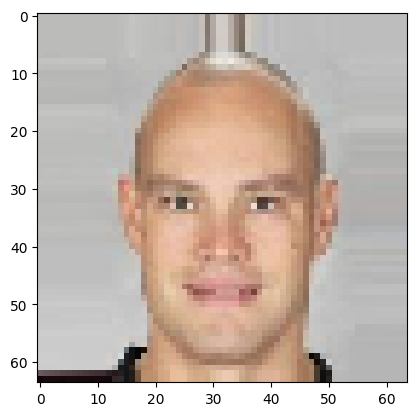

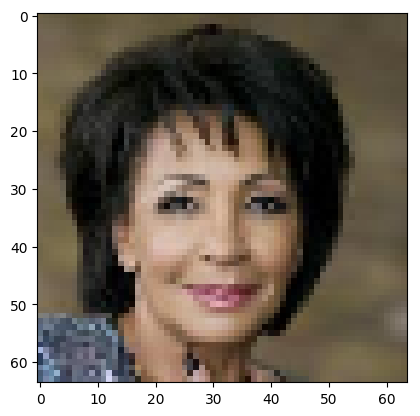

In [5]:
dataloader = DataLoader(Dataset_GAN(), batch_size=1, shuffle=True)
for i, data in enumerate(dataloader):
    image = data.squeeze().numpy().transpose([1,2,0])
    plt.imshow(image / 2 + 0.5)
    plt.show()
    if i >= 1:
        break


# Network Structure

In [6]:
class CNA(nn.Layer):
    #
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, conv, norm, act):
        super().__init__()
        if conv == 'conv':
            self.layers = nn.LayerList([nn.Conv2D(in_channels, out_channels, kernel_size, stride, padding, weight_attr=nn.initializer.Normal(0., 0.02), bias_attr=False)])
        if conv == 'tconv':
            self.layers = nn.LayerList([nn.Conv2DTranspose(in_channels, out_channels, kernel_size, stride, padding, weight_attr=nn.initializer.Normal(0., 0.02), bias_attr=False)])
        if norm == 'bn':
            self.layers.append(nn.BatchNorm2D(out_channels))
        if act == 'relu':
            self.layers.append(nn.ReLU())
        if act == 'lrelu':
            self.layers.append(nn.LeakyReLU(0.2))
    #
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

## Generator

In [7]:
class Generator(nn.Layer):
    #
    def __init__(self, dim_latent=dim_latent, channel=channel_g):
        super().__init__()
        self.layers = nn.Sequential(
            CNA(dim_latent, channel*8, 4, 1, 0, 'tconv', 'bn', 'relu'),
            CNA(channel*8, channel*4, 4, 2, 1, 'tconv', 'bn', 'relu'),
            CNA(channel*4, channel*2, 4, 2, 1, 'tconv', 'bn', 'relu'),
            CNA(channel*2, channel, 4, 2, 1, 'tconv', 'bn', 'relu'),
            CNA(channel, 3, 4, 2, 1, 'tconv', False, False)
        )
    #
    def forward(self, x):
        return F.tanh(self.layers(x))

## Discriminator

In [8]:
class Discriminator(nn.Layer):
    #
    def __init__(self, channel=channel_d):
        super().__init__()
        self.layers = nn.Sequential(
            CNA(3, channel, 4, 2, 1, 'conv', False, 'lrelu'),
            CNA(channel, channel*2, 4, 2, 1, 'conv', 'bn', 'lrelu'),
            CNA(channel*2, channel*4, 4, 2, 1, 'conv', 'bn', 'lrelu'),
            CNA(channel*4, channel*8, 4, 2, 1, 'conv', 'bn', 'lrelu'),
            nn.Conv2D(channel*8, 1, 4, weight_attr=nn.initializer.Normal(0., 0.02), bias_attr=False)
        )
    #
    def forward(self, x):
        return self.layers(x).reshape([-1,1])

# Show

In [9]:
@P.no_grad()
def show(net=None, row=2, col=4):
    if net is None:
        net = Generator()
    net.eval()
    y = net(P.randn([row*col, dim_latent, 1, 1])).numpy().transpose([0,2,3,1])
    print(np.max(y), np.min(y))
    plt.figure(figsize=(16,8))
    for i in range(row*col):
        image = (y[i,:,:,:] + 1) / 2
        plt.subplot(row, col, i+1), plt.imshow(image)
    plt.show()

0.014077435 -0.013262436


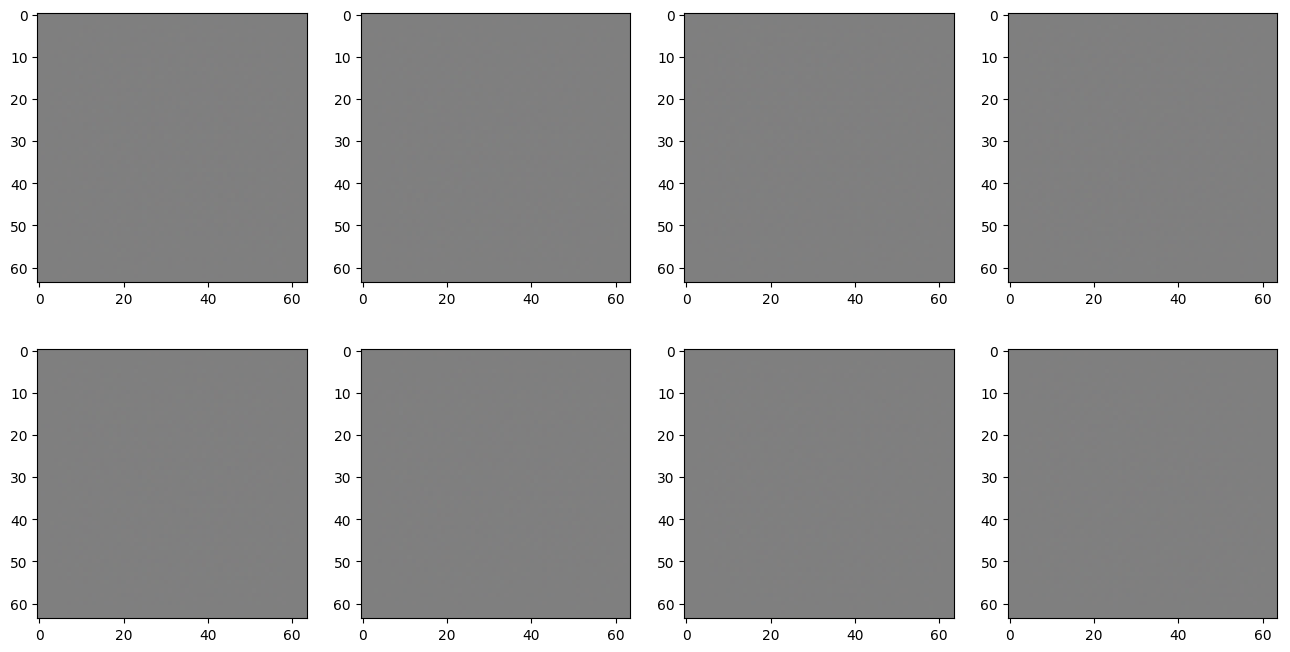

In [10]:
show()

# Train

In [11]:
def trainer_d(net_d, optimizer_d, net_g, image_real):
    #
    src_real = net_d(image_real)
    image_fake = net_g(P.randn([image_real.shape[0], dim_latent, 1, 1]))
    src_fake = net_d(image_fake.detach())
    #
    loss = F.binary_cross_entropy_with_logits(src_real, P.ones_like(src_real)) + F.binary_cross_entropy_with_logits(src_fake, P.zeros_like(src_fake))
    #
    optimizer_d.clear_grad()
    loss.backward()
    optimizer_d.step()

In [12]:
def trainer_g(net_g, optimizer_g, net_d, image_real):
    #
    image_fake = net_g(P.randn([image_real.shape[0], dim_latent, 1, 1]))
    src_fake = net_d(image_fake)
    #
    src_real = net_d(image_real)
    loss = P.mean((P.log(F.sigmoid(src_fake)+1e-8) - P.log(1-F.sigmoid(src_fake)+1e-8)) ** 2) / 2
    #
    optimizer_g.clear_grad()
    loss.backward()
    optimizer_g.step()

In [13]:
def train(batch_size, epochs, load_model):
    #
    net_d = Discriminator()
    net_d.train()
    net_g = Generator()
    net_g.train()
    optimizer_d = P.optimizer.Adam(parameters=net_d.parameters(), learning_rate=learning_rate, beta1=0.5)
    optimizer_g = P.optimizer.Adam(parameters=net_g.parameters(), learning_rate=2*learning_rate, beta1=0.5)
    if load_model:
        net_d.set_state_dict(P.load(path_work + 'net_d.pdparams'))
        net_g.set_state_dict(P.load(path_work + 'net_g.pdparams'))
    #
    iteration = 0
    for epoch in range(epochs):
        dataloader = DataLoader(Dataset_GAN(), batch_size=batch_size, shuffle=True)
        for image in dataloader:
            trainer_d(net_d, optimizer_d, net_g, image)
            iteration += 1
            if iteration % step_g == 0:
                trainer_g(net_g, optimizer_g, net_d, image)
    #
            if iteration % 1000 == 0:
                print('Epoch: ', epoch, ', Iteration: ', iteration)
                P.save(net_d.state_dict(), path_work + 'net_d.pdparams')
                P.save(net_g.state_dict(), path_work + 'net_g.pdparams')
                show(net_g)
                net_g.train()

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:712: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance."


Epoch:  0 , Iteration:  1000
0.9996925 -0.99947625


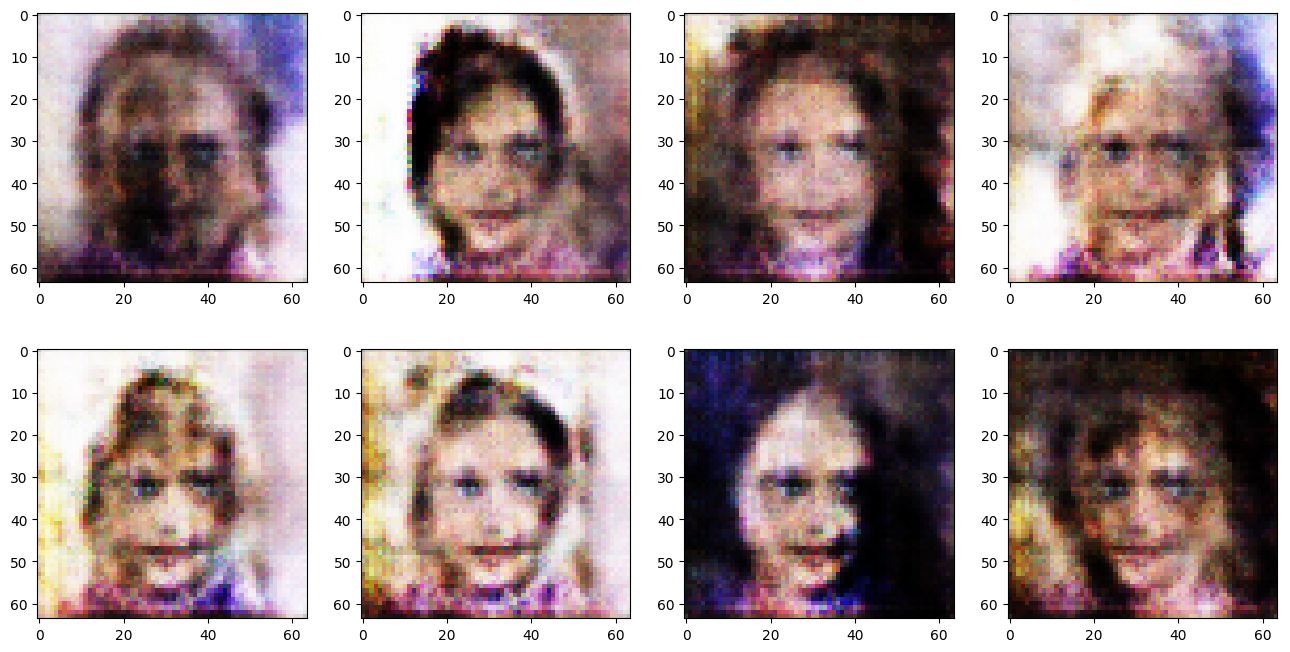

Epoch:  1 , Iteration:  2000
0.9998002 -1.0


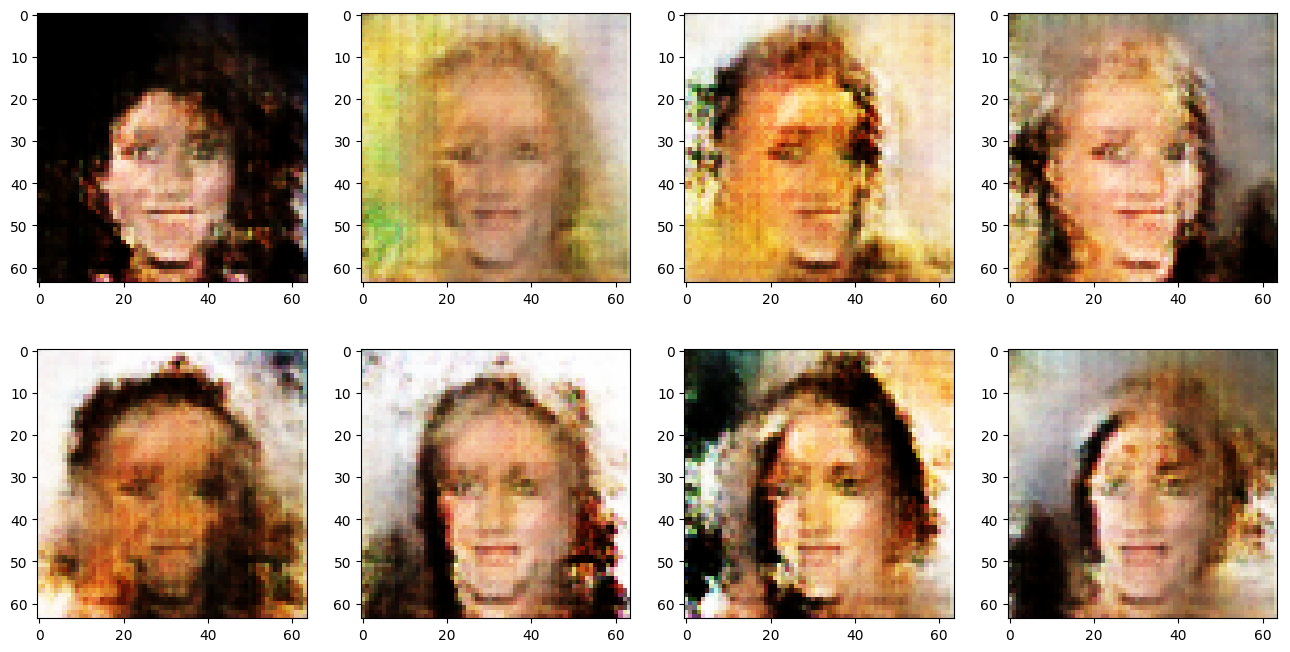

Epoch:  1 , Iteration:  3000
0.9999998 -1.0


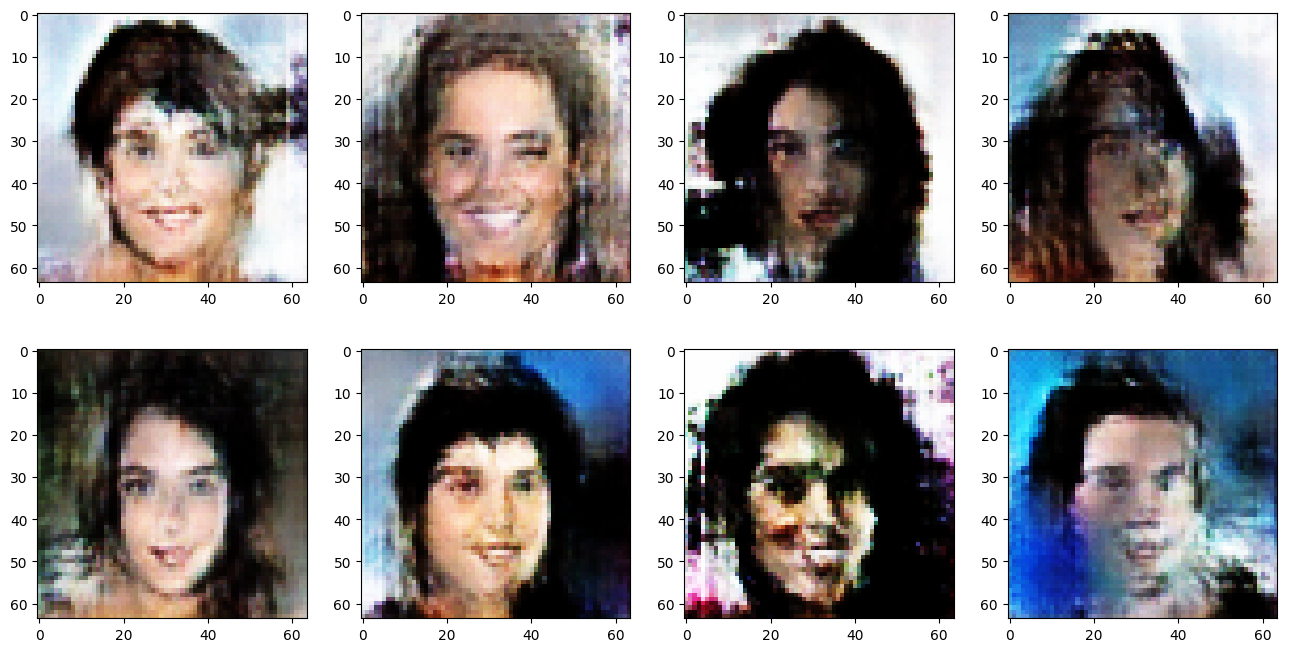

Epoch:  2 , Iteration:  4000
0.9999986 -1.0


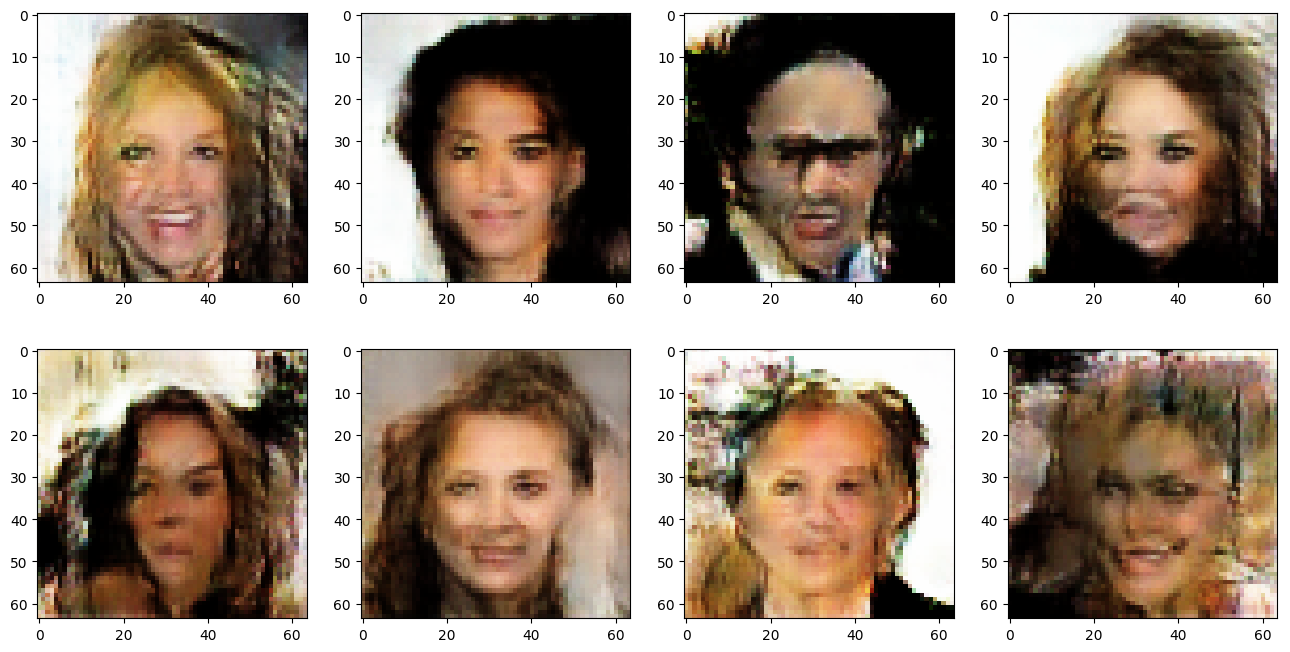

Epoch:  3 , Iteration:  5000
0.9999927 -0.9999999


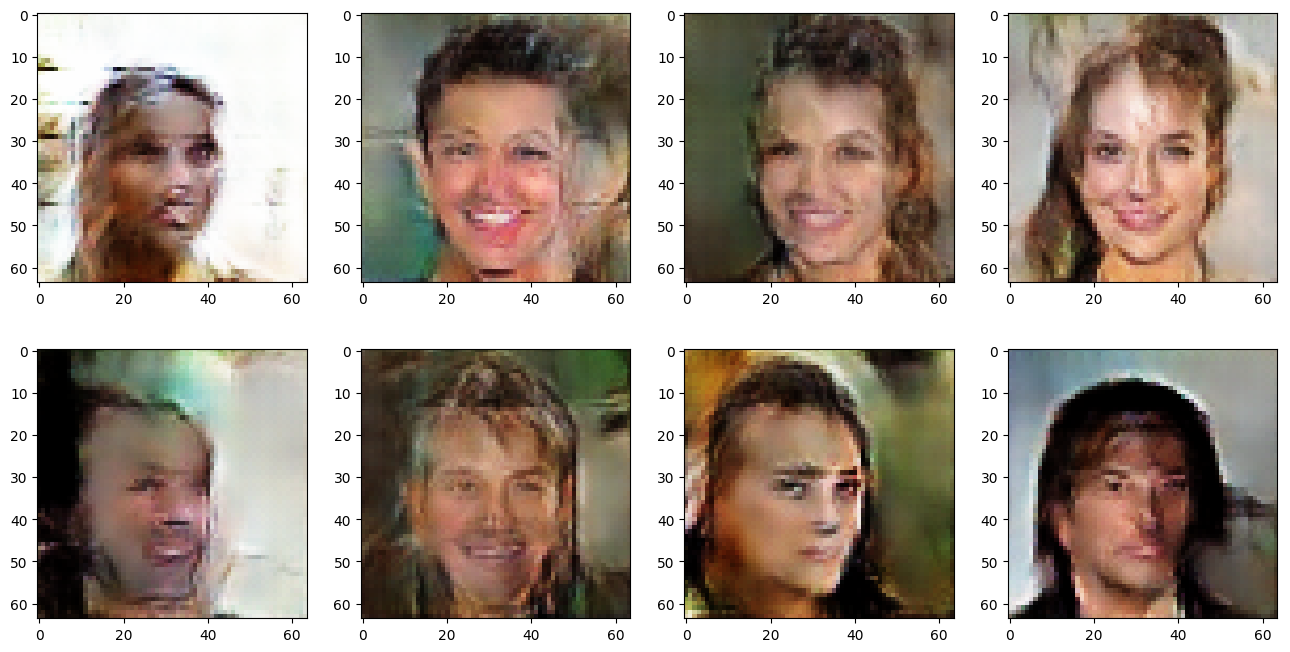

Epoch:  3 , Iteration:  6000
0.99999887 -0.99999994


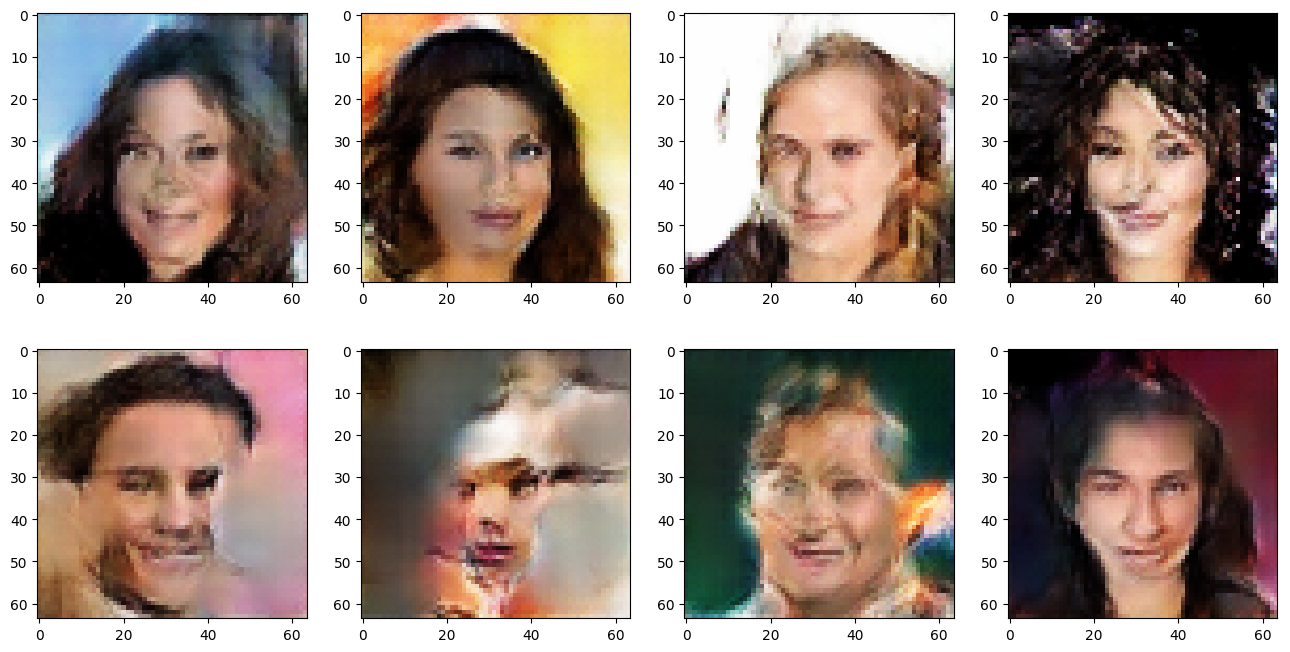

Epoch:  4 , Iteration:  7000
0.9833127 -1.0


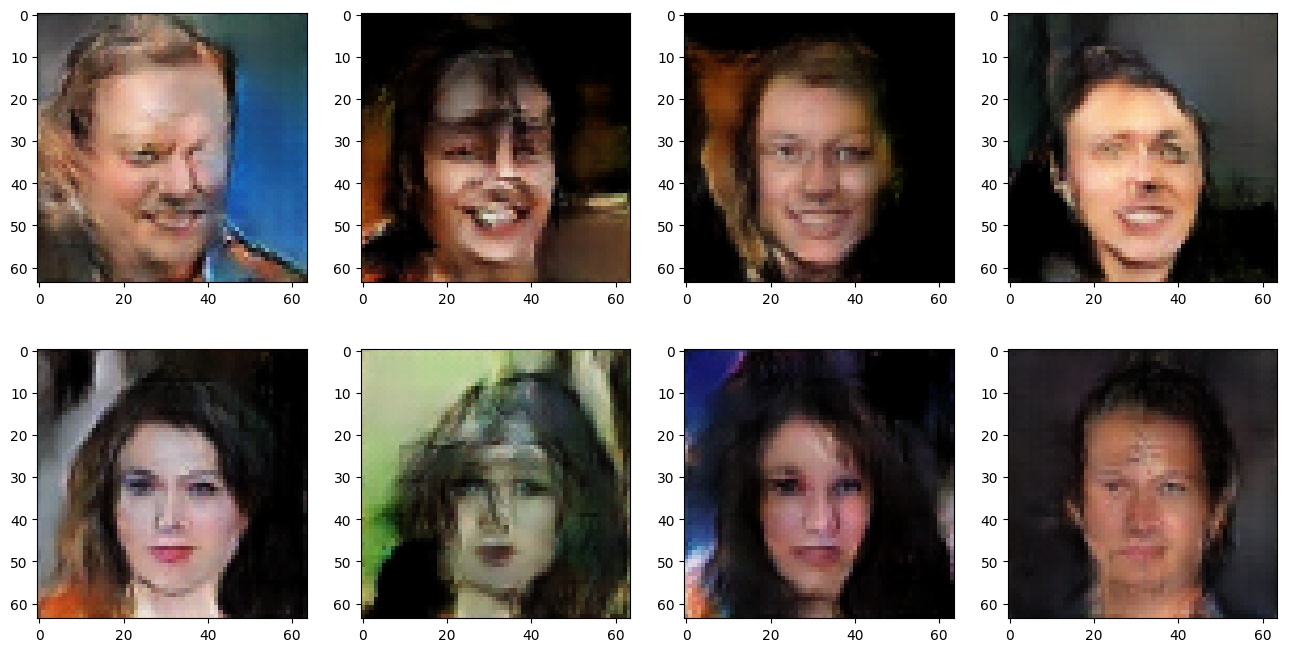

In [14]:
train(batch_size=batch_size, epochs=5, load_model=False)

In [15]:
# train(batch_size=batch_size, epochs=epochs, load_model=True)

# Test

0.99999666 -1.0


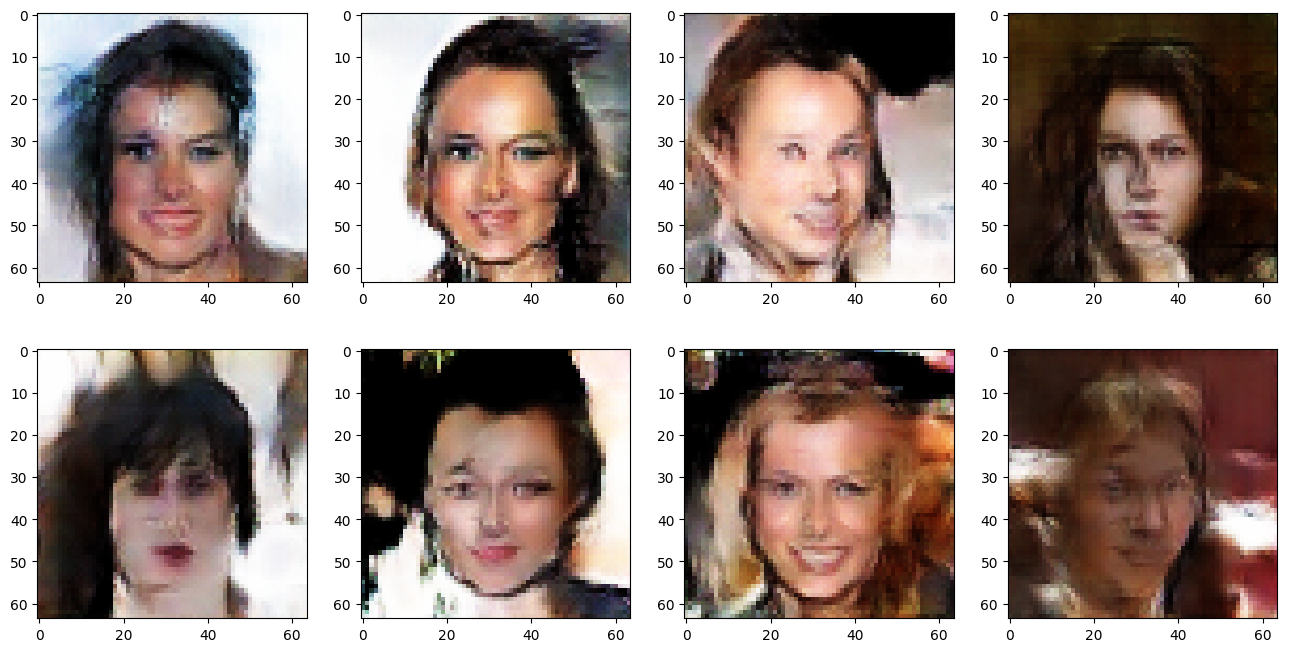

In [16]:
G = Generator()
G.set_state_dict(P.load(path_work + 'net_g.pdparams'))
show(G)